# Import Library

In [23]:
import torch
import torch.nn as nn
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

from torchvision import models
from matplotlib import pyplot as plt

**Kiểm tra GPU**
Nếu gpu sẵn sàng thì hiển thị cuda:0 và nếu ko hiển thị cpu

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**Import vgg19 model**

In [25]:
vgg19 = models.vgg19(pretrained=True).features.eval()

#Các layer sẽ sử dụng để đại diện cho các đặc trưng của contentLayer, styleLayers
contentLayerName = ['conv4']
styleLayerNames = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']

**Xây dựng hàm load ảnh và hiển thị ảnh**

In [26]:
def ImageLoader(image_path, size=(300, 480)):
    h, w = size
    image = Image.open(image_path).resize((w, h))
    image = transforms.ToTensor()(image).unsqueeze(0)
    return image

def ImageShow(tensor, title, size=(10, 8), save=False):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    if save: #Lưu ảnh
        image.save(title+".jpg")
    plt.figure(figsize=size)
    plt.imshow(image)
    plt.title(title)
    plt.show()

# MODELING

**Xây dựng hàm ma trận gram matrix**

In [27]:


def gram_matrix(image):
    N, C, H, W = image.size()
    features = image.view(N * C, H * W)
    gram = torch.mm(features, features.t())
    return torch.div(gram, N * C * H * W)

* N: Batch Size
* C: Channels
* H: Height
* W: Width

**Chuẩn hóa ảnh đầu vào vào cách tạo 1 class tên Normalization sử dụng kĩ thuật biến đổi dữ liệu standardization và class này sẽ được thêm vào model mới do ta tạo**

In [28]:


class Normalization(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, image):
        dev = image.device
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(dev)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(dev)
        return (image - mean)/std



Xây dựng lớp content loss và styleloss và cho phép kế thừa
**văn bản in đậm**

In [29]:
class ContentLossLayer(nn.Module):

    def __init__(self, target):
        super().__init__()
        self.target = target.detach()

    def forward(self, pred):
        self.loss = torch.mean((pred - self.target)**2)
        return pred


class StyleLossLayer(nn.Module):

    def __init__(self, target):
        super().__init__()
        self.target = target.detach()

    def forward(self, pred):
        pred_gram = gram_matrix(pred)
        target_gram = gram_matrix(self.target)
        self.loss = torch.mean((pred_gram - target_gram)**2)
        return pred

**Xây dựng model mới giữ lại các lớp trung gian cần thiết của mô hình pre trained vgg19 việc này giúp tối ưu hóa quá trình tối ưu ảnh đầu ra**

In [30]:
class Compiler():
    def __init__(self, baseModel, contentLayerName, styleLayerNames, device='cuda:0'):
        self.baseModel = baseModel.to(device)
        self.contentLayerName = contentLayerName
        self.styleLayerNames = styleLayerNames


    def compile(self, contentImage, styleImage, device='cuda:0'):
        contentImage = contentImage.to(device)
        styleImage = styleImage.to(device)
        contentLayers=[]
        styleLayers=[]

        # Khởi tạo model
        model = nn.Sequential()
        model.add_module('norm', Normalization())
        i = 0
        for layer in self.baseModel.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in self.contentLayerName:
                target = model(contentImage).detach()
                layer = ContentLossLayer(target)
                model.add_module("content{}".format(i), layer)
                contentLayers.append(layer)

            if name in self.styleLayerNames:
                target = model(styleImage).detach()
                layer = StyleLossLayer(target)
                model.add_module("style{}".format(i), layer)
                styleLayers.append(layer)
        for i in range(len(model) - 1, -1, -1):    #Backward
            if isinstance(model[i], ContentLossLayer) or isinstance(model[i], StyleLossLayer):
                break
        model = model[:(i + 1)]
        return model, contentLayers, styleLayers

Muốn biết các lớp trong model mới ta cùng câu lệnh #print(model)

# Trainer

**Sử dụng LBFGS và anpha = 1, beta = 1e6**
Ở đây ta dùng LBFGS vì nó không cập nhập trọng số mô hình nên giúp quá trình hội tụ nhanh chóng hơn

In [31]:
class Trainer():
    def __init__(self, model, contentLayers, styleLayers, device='cuda:0'):
        self.model = model.to(device)
        self.contentLayers = contentLayers
        self.styleLayers = styleLayers

    def fit(self, image, epochs=50, alpha=1, betta=1e6, device='cuda:0'):
        image = image.to(device)
        optimizer = torch.optim.LBFGS([image.requires_grad_(True)])

        #Tạo list lưu giá trị của các loss qua các vòng lặp
        content_losses=[]
        style_losses=[]
        total_losses=[]

        for epoch in range(1, epochs+1):
            def closure():
                image.clamp(0, 1)
                optimizer.zero_grad()
                self.model(image)

                content_loss=0.
                style_loss=0.

                for contentLayer in self.contentLayers:
                    content_loss += contentLayer.loss
                for styleLayer in self.styleLayers:
                    style_loss += styleLayer.loss

                loss = alpha*content_loss + betta*style_loss
                loss.backward()
                content_losses.append(alpha*content_loss.item())
                style_losses.append(betta*style_loss.item())
                total_losses.append(loss.item())
                return loss
            optimizer.step(closure)

            print('Epoch {}/{} --- Total Loss: {:.4f} '.format(epoch, epochs, total_losses[-1]))
            print('Content Loss: {:4f} --- Style Loss : {:4f}'.format(content_losses[-1], style_losses[-1]))
            print('---'*17)
        losses={'total': total_losses, 'content': content_losses, 'style': style_losses}
        return losses, torch.clamp(image, 0, 1)

# Thực nghiệm với bộ dữ liệu 1

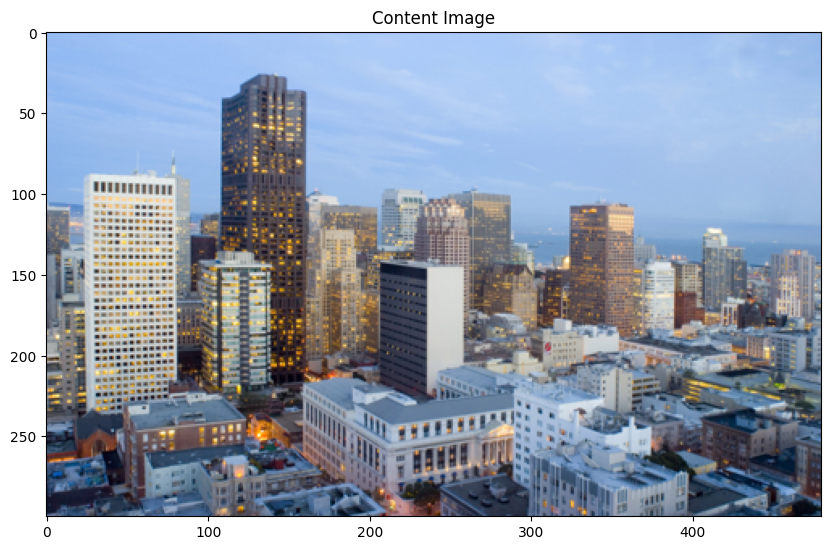

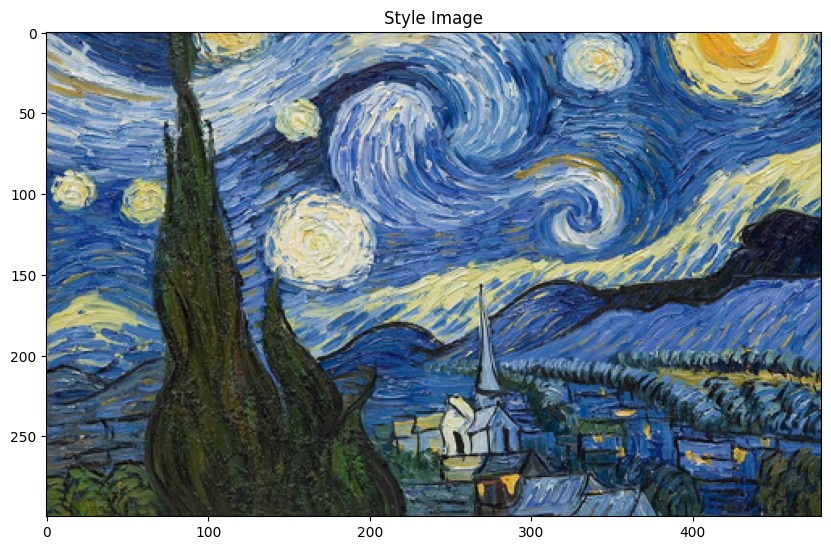

In [32]:
contentImage = ImageLoader("/kaggle/input/dataset-da2/City.png")
styleImage = ImageLoader("/kaggle/input/dataset-da2/StarryNight.jpg")

ImageShow(contentImage, title='Content Image')
ImageShow(styleImage, title='Style Image')

# Compile

In [33]:
compiler = Compiler(vgg19, contentLayerName, styleLayerNames, device)
model, contentLayers, styleLayers = compiler.compile(contentImage, styleImage, device)

# Train

In [34]:
trainer = Trainer(model, contentLayers, styleLayers, device)

inputImage = contentImage.clone()
# Nếu muốn bắt đầu từ ảnh nhiễu trắng ta sử dụng câu lệnh dưới đây
#inputImage = torch.randn(content_img.data.size(), device=device)
losses, outImage = trainer.fit(inputImage)

Epoch 1/50 --- Total Loss: 268.4969 
Content Loss: 17.464447 --- Style Loss : 251.032499
---------------------------------------------------
Epoch 2/50 --- Total Loss: 134.7732 
Content Loss: 19.221788 --- Style Loss : 115.551411
---------------------------------------------------
Epoch 3/50 --- Total Loss: 92.7925 
Content Loss: 20.271568 --- Style Loss : 72.520983
---------------------------------------------------
Epoch 4/50 --- Total Loss: 66.4157 
Content Loss: 20.497263 --- Style Loss : 45.918459
---------------------------------------------------
Epoch 5/50 --- Total Loss: 49.7756 
Content Loss: 20.045088 --- Style Loss : 29.730500
---------------------------------------------------
Epoch 6/50 --- Total Loss: 41.1287 
Content Loss: 19.274126 --- Style Loss : 21.854548
---------------------------------------------------
Epoch 7/50 --- Total Loss: 35.6683 
Content Loss: 18.223497 --- Style Loss : 17.444841
---------------------------------------------------
Epoch 8/50 --- Total Lo

# Results

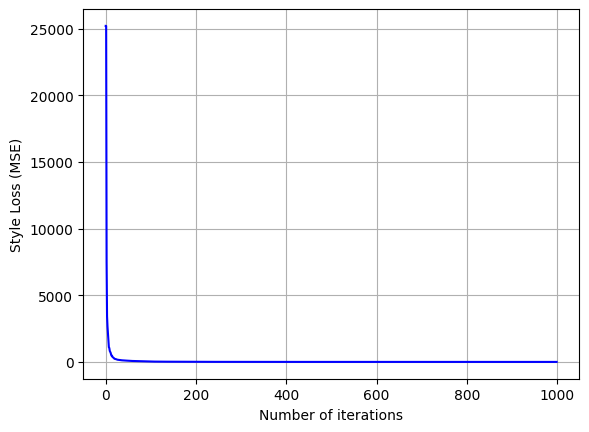

In [35]:
tloss = losses['total']
closs = losses['content']
sloss = losses['style']

plt.plot(sloss, 'b-')
plt.xlabel('Number of iterations')
plt.ylabel('Style Loss (MSE)')
plt.grid()

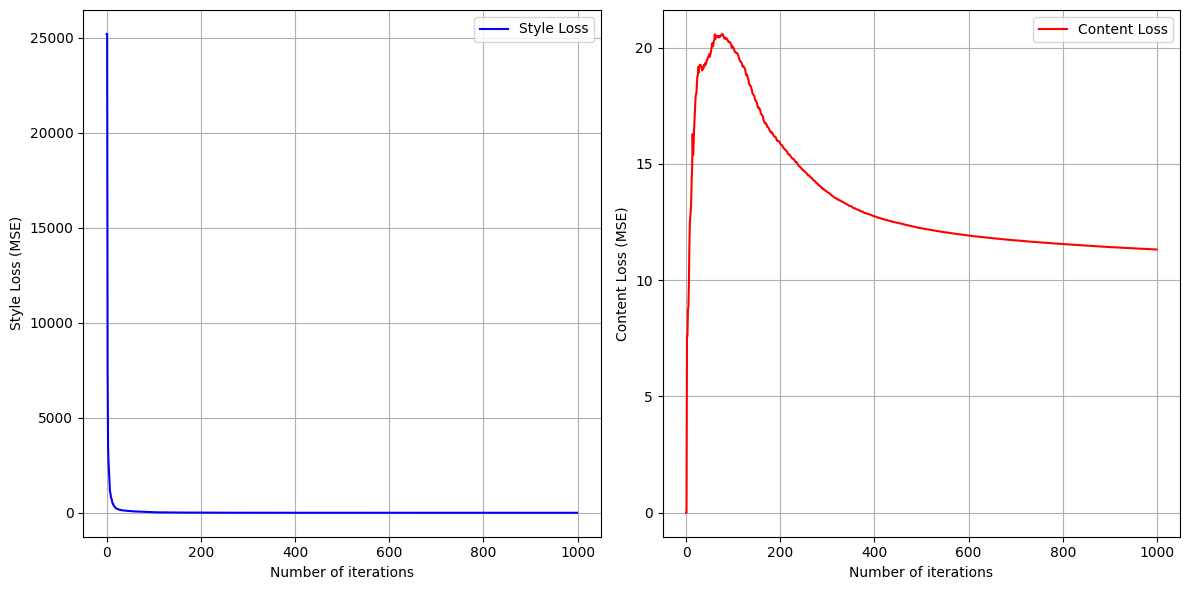

In [36]:

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Vẽ đồ thị của style loss trong cột đầu tiên
axs[0].plot(sloss, 'b-', label='Style Loss')
axs[0].set_xlabel('Number of iterations')
axs[0].set_ylabel('Style Loss (MSE)')
axs[0].grid()
axs[0].legend()

# Vẽ đồ thị của content loss trong cột thứ hai
axs[1].plot(closs, 'r-', label='Content Loss')
axs[1].set_xlabel('Number of iterations')
axs[1].set_ylabel('Content Loss (MSE)')
axs[1].grid()
axs[1].legend()

# Hiển thị đồ thị
plt.tight_layout()
plt.show()


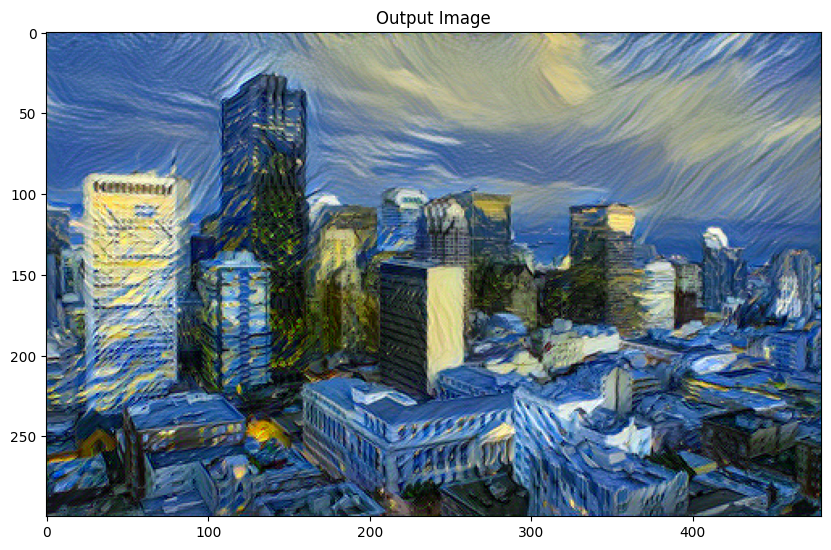

In [37]:
ImageShow(outImage, title='Output Image')

# Thực nghiệm với bộ dữ liệu 2

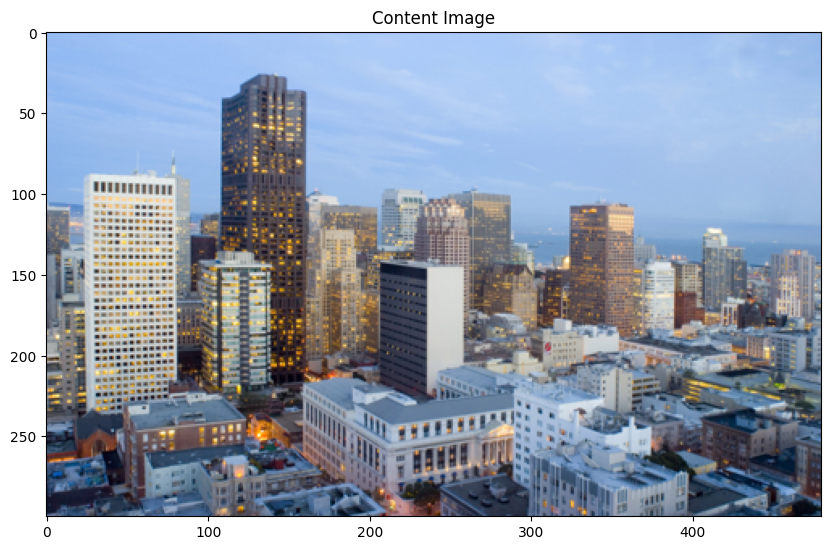

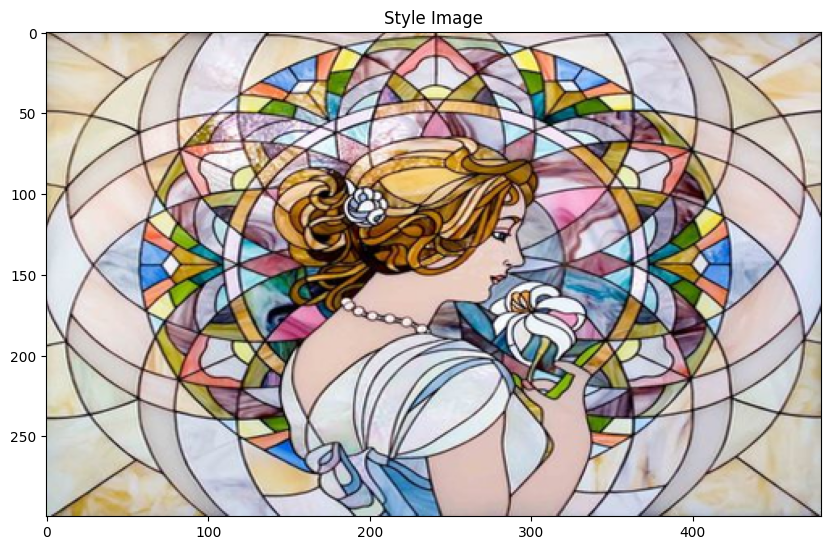

In [38]:
contentImage = ImageLoader("/kaggle/input/dataset-da2/City.png")
styleImage = ImageLoader("/kaggle/input/dataset-da2/s3.jpg")

ImageShow(contentImage, title='Content Image')
ImageShow(styleImage, title='Style Image')

# Compile model

In [39]:
compiler = Compiler(vgg19, contentLayerName, styleLayerNames, device)
model, contentLayers, styleLayers = compiler.compile(contentImage, styleImage, device)

# Train

In [40]:
trainer = Trainer(model, contentLayers, styleLayers, device)

inputImage = contentImage.clone()
losses, outImage = trainer.fit(inputImage)

Epoch 1/50 --- Total Loss: 3507.2703 
Content Loss: 42.558701 --- Style Loss : 3464.711597
---------------------------------------------------
Epoch 2/50 --- Total Loss: 662.4111 
Content Loss: 49.865528 --- Style Loss : 612.545584
---------------------------------------------------
Epoch 3/50 --- Total Loss: 264.6155 
Content Loss: 52.253723 --- Style Loss : 212.361818
---------------------------------------------------
Epoch 4/50 --- Total Loss: 181.7187 
Content Loss: 53.508999 --- Style Loss : 128.209693
---------------------------------------------------
Epoch 5/50 --- Total Loss: 125.3511 
Content Loss: 53.839546 --- Style Loss : 71.511553
---------------------------------------------------
Epoch 6/50 --- Total Loss: 104.0913 
Content Loss: 53.801590 --- Style Loss : 50.289753
---------------------------------------------------
Epoch 7/50 --- Total Loss: 95.1150 
Content Loss: 53.279484 --- Style Loss : 41.835552
---------------------------------------------------
Epoch 8/50 --- 

# Results

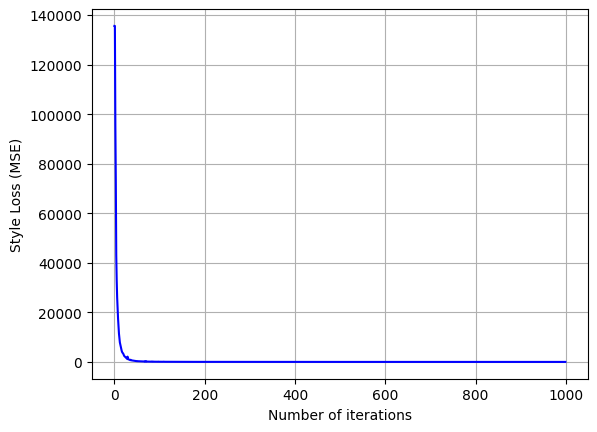

In [41]:
tloss = losses['total']
closs = losses['content']
sloss = losses['style']

plt.plot(sloss, 'b-')
plt.xlabel('Number of iterations')
plt.ylabel('Style Loss (MSE)')
plt.grid()

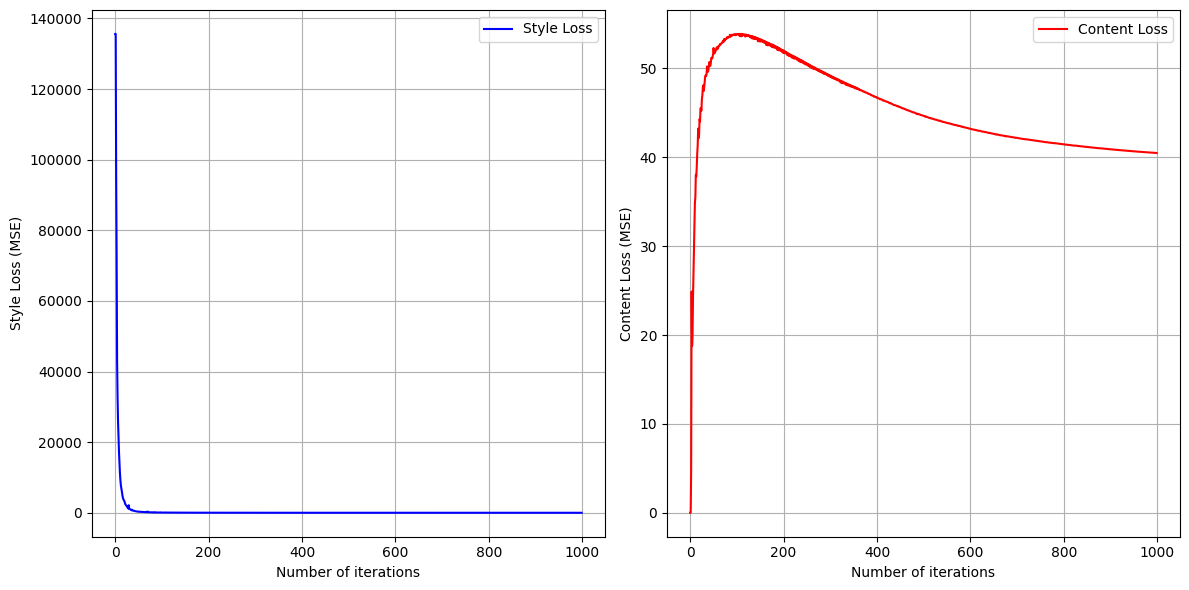

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Vẽ đồ thị của style loss trong cột đầu tiên
axs[0].plot(sloss, 'b-', label='Style Loss')
axs[0].set_xlabel('Number of iterations')
axs[0].set_ylabel('Style Loss (MSE)')
axs[0].grid()
axs[0].legend()

# Vẽ đồ thị của content loss trong cột thứ hai
axs[1].plot(closs, 'r-', label='Content Loss')
axs[1].set_xlabel('Number of iterations')
axs[1].set_ylabel('Content Loss (MSE)')
axs[1].grid()
axs[1].legend()

# Hiển thị đồ thị
plt.tight_layout()
plt.show()


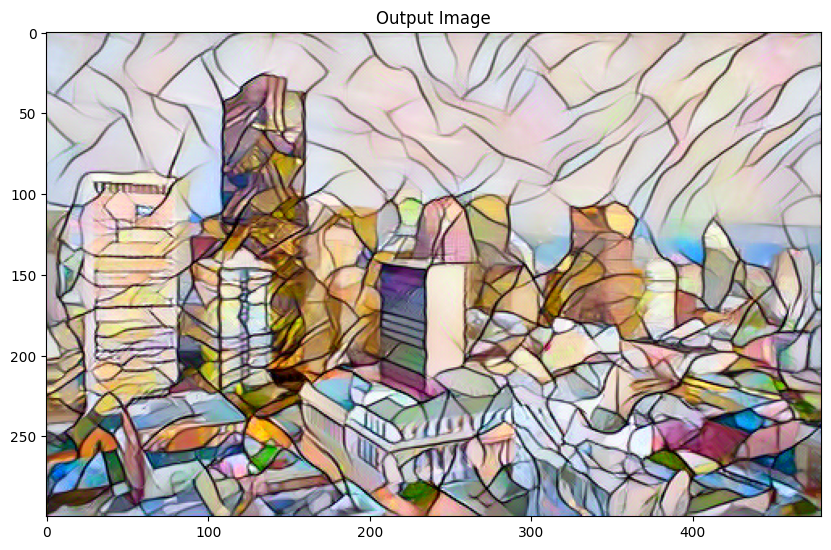

In [43]:
ImageShow(outImage, title='Output Image')

## Trích xuất visualize từ các layer ta cần từ đó chứng minh chỉ nên sử dụng 1 số lớp convolution thay vì toàn bộ mạng, điều đó mới phù hợp với yêu cầu bài toán

Hiển thị 4 feature maps ngẫu nhiên của layer 0:


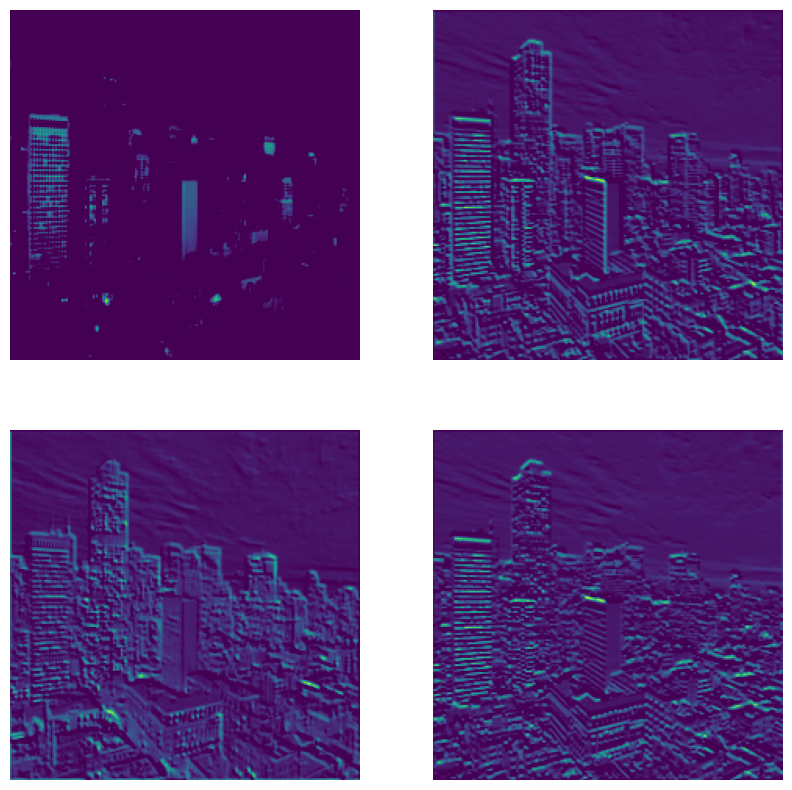

Hiển thị 4 feature maps ngẫu nhiên của layer 5:


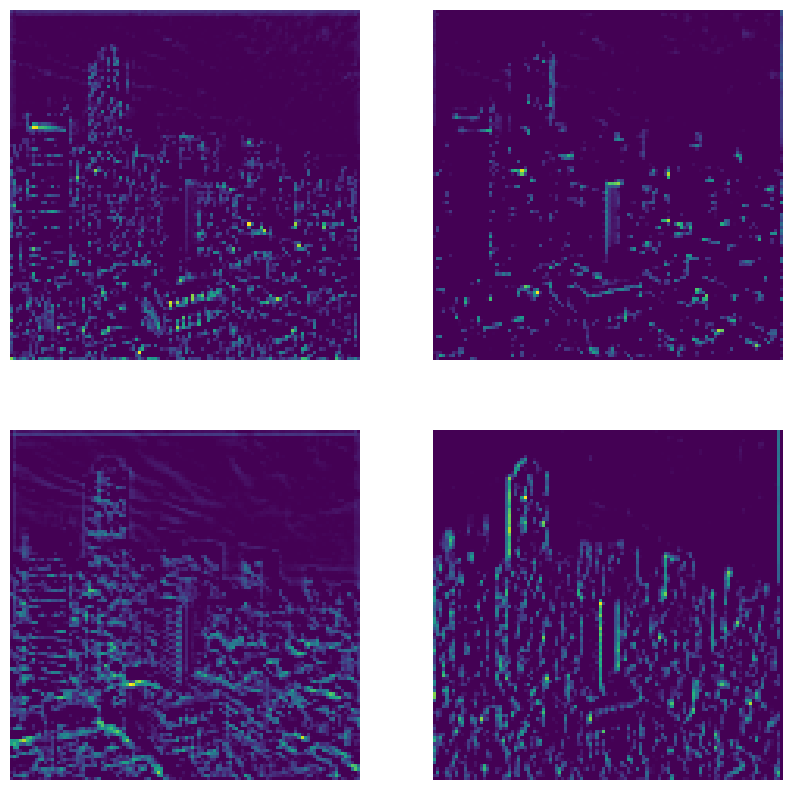

Hiển thị 4 feature maps ngẫu nhiên của layer 10:


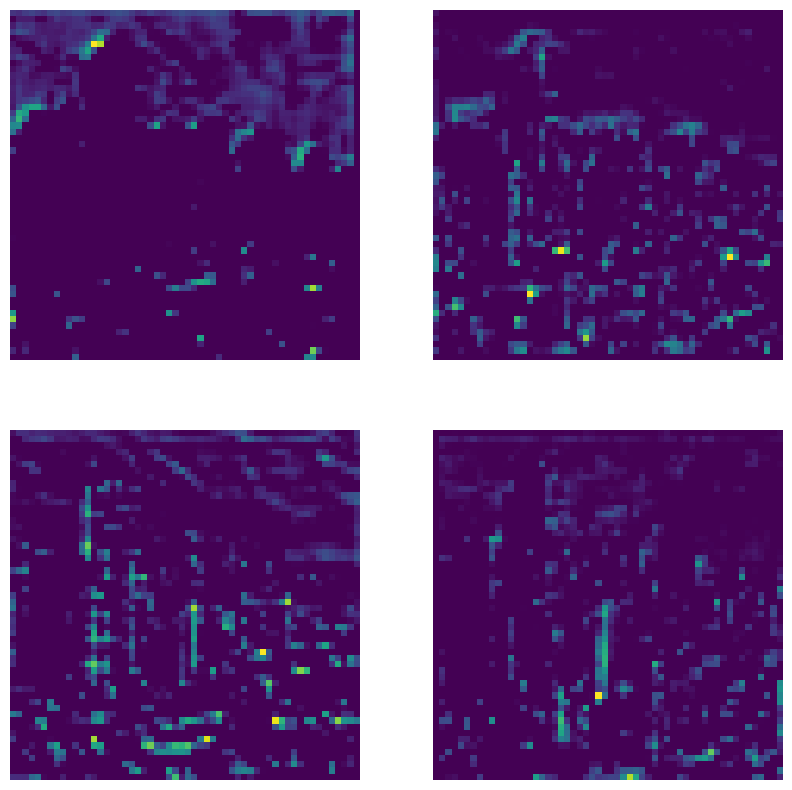

Hiển thị 4 feature maps ngẫu nhiên của layer 15:


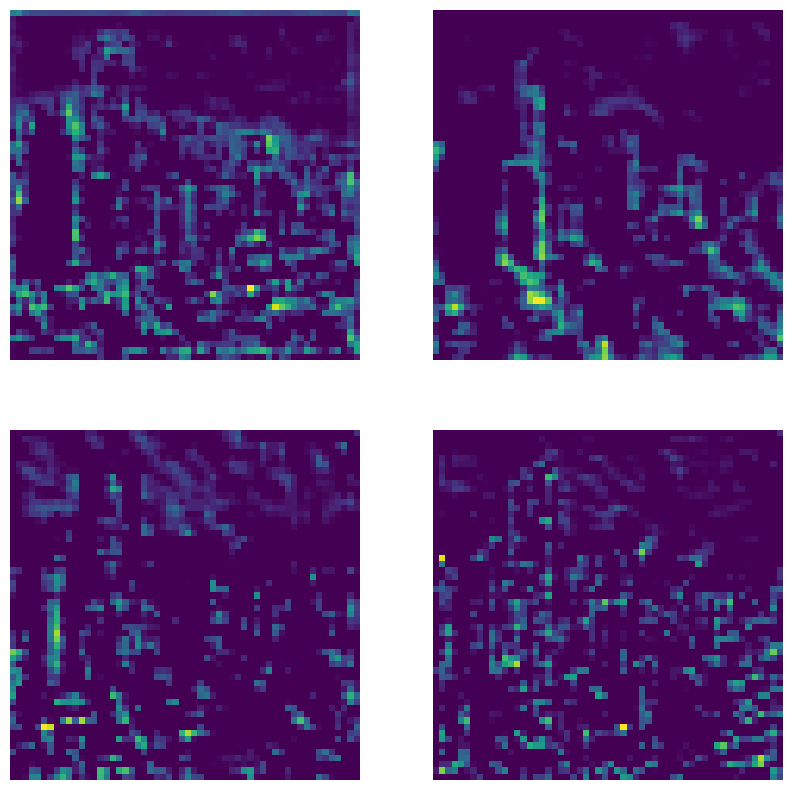

Hiển thị 4 feature maps ngẫu nhiên của layer 17:


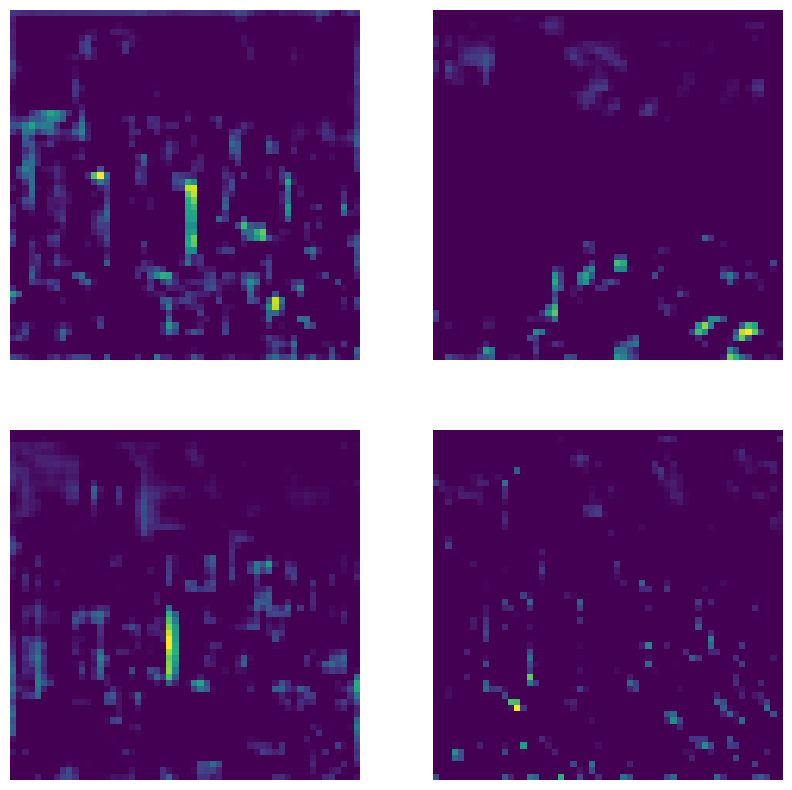

In [46]:
import torch
import torch.nn as nn
from torchvision.models import vgg19
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import random

# Lớp để lấy output từ các layer mong muốn
class VGGFeatureExtractor(torch.nn.Module):
    def __init__(self, model, selected_layers):
        super(VGGFeatureExtractor, self).__init__()
        self.model = model
        self.selected_layers = selected_layers

    def forward(self, x):
        outputs = []
        for idx, layer in enumerate(self.model):
            x = layer(x)
            if idx in self.selected_layers:
                outputs.append(x)
        return outputs

# Tải mô hình VGG19
vgg = vgg19(pretrained=True).features[:18].to("cuda").eval()
selected_layers = [0, 5, 10, 15, 17]  # Các layer cần lấy output
feature_extractor = VGGFeatureExtractor(vgg, selected_layers)

# Chuẩn bị input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Đường dẫn ảnh gốc
image = Image.open("/kaggle/input/dataset-da2/City.png").convert("RGB")
input_tensor = transform(image).unsqueeze(0).to("cuda")

# Lấy output từ các layer
with torch.no_grad():
    outputs = feature_extractor(input_tensor)

for layer_idx, fm in enumerate(outputs):
    print(f"Hiển thị 4 feature maps ngẫu nhiên của layer {selected_layers[layer_idx]}:")
    # Chuyển dữ liệu sang CPU và numpy
    fm = fm.squeeze(0).cpu().numpy()  # (channels, height, width)
    num_channels = fm.shape[0]

    # Chọn ngẫu nhiên 4 feature maps
    selected_indices = random.sample(range(num_channels), 4)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 grid để hiển thị 4 feature maps
    for idx, ax in enumerate(axs.ravel()):
        if idx < 4:
            ax.imshow(fm[selected_indices[idx]], cmap="viridis")
            ax.axis("off")
    plt.show()


**END**